In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Classifying Digits with Convolutional Neural Net (CNN)

### Read Data
The **batch size** is the number of samples passed through the neural net at a time. So if there are 1,000 samples and your batch size is 100 then for each epoch there will be 1,000/100 = 10 batches passed through the net. An advantage is if you have one billion samples and you don't have the computing power (memory) to pass it all at once. Also it's been shown that networks train faster using batches smaller than the entire sample.

The data is downloaded from pytorch module and stored in the root file. The pytorch class DataLoader is used to load the data set into the environment. Typically we would like to normalize the data and the transform argument in DataLoader class is a nice place to pass a Compose class that contains both the ToTensor conversion as well as Normalize function. In this case we'll just do the ToTensor conversion and calculate the mean and std dev in a moment which can be used in the future.

In [2]:
batch_size_train = 64
train_mnist = torchvision.datasets.MNIST('C:/projects/summer2020/vision/digits/', train=True, download=True,
                        transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_mnist, batch_size=batch_size_train, shuffle=True)

In [3]:
batch_size_test = 1000
test_mnist = torchvision.datasets.MNIST('C:/projects/summer2020/vision/digits/', train=False, download=True,
                        transform=torchvision.transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_mnist,batch_size=batch_size_test, shuffle=True)

### Structure of data
The data train_loader and test_loader are pytorch DataLoader classes. The train data set has 60,000 images while the test set has 10,000. The structure of the object train_loader is of length n_images/batch_size = 60,000/64 = 938. Then we'll plot one of the data points.

In [4]:
len(train_loader)

938

In [5]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

([], <a list of 0 Text yticklabel objects>)

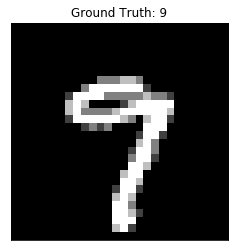

In [7]:
plt.imshow(example_data[0][0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(example_targets[0]))
plt.xticks([])
plt.yticks([])

### Construct the neural net
It's typical to create a neural network as an object to hold the structure of the model. We'll step through each line in the constructor and the class method 'forward'.

Constructor:
- self.conv1: The first layer. It takes 1 channel in (the image) and returns 10 channels. The kernel size is 5x5.
- self.conv2: The second layer. It takes 10 channels in (from layer one) and returns 20 channels. Also kernel size of 5x5.
- self.conv2_drop: 
- self.fc1:
- self.fc2:

'forward' method:


In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
n_epochs = 3
learning_rate = 0.01
momentum = 0.5
log_interval = 10

In [10]:
network = Net()
# optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [12]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))


In [13]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [14]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

C:\Users\scott\Anaconda3\envs\general-vision\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\scott\Anaconda3\envs\general-vision\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3038, Accuracy: 1028/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.315575
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.297130
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.082996
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.537947
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.782610
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.696118
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.340441
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.337012
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.451793
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.270911
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.131800
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.154038
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.328714
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.910683
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.281817
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.850208
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.213740
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.079012
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.348181
Train Epoch: 1 [12160

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.970041
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.650890
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.803532
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.646031
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.977762
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.867015
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.664872
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.639358
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.524018
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.401496
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.451480
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.640849
Train Epoch: 2 [51840/60000 (86%)]	Loss: 1.010031
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.659223
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.885387
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.854680
Train Epoch: 2 [54400/60000 (91%)]	Loss: 1.353214
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.938676
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.706881
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.636154


Text(0, 0.5, 'negative log likelihood loss')

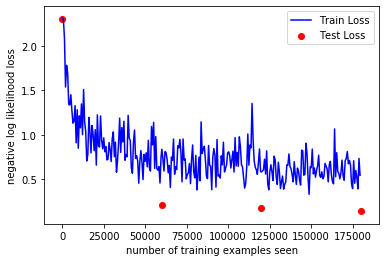

In [15]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [16]:
with torch.no_grad():
  output = network(example_data)

C:\Users\scott\Anaconda3\envs\general-vision\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


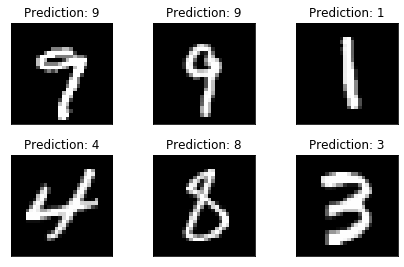

In [17]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])